In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as tf_hub
import time
import numpy as np
import os
from bert.tokenization import FullTokenizer
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import text_normalizer as tn

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tf.logging.set_verbosity(tf.logging.INFO)
SEED = 42
np.random.seed(SEED)
tf.set_random_seed(SEED)

%matplotlib inline

W0702 04:07:46.107047 139846337992512 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
print(tf.__version__)
print(tf_hub.__version__)

1.12.0
0.4.0


In [3]:
print(tf.test.is_gpu_available())
print(tf.test.gpu_device_name())

True
/device:GPU:0


In [4]:
! nvidia-smi

Tue Jul  2 04:10:12 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    28W /  70W |    213MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [14]:
dataset = pd.read_csv('./data/GH_complete_labeled_issues_prs - preprocessed.csv', encoding='utf-8', 
                      na_filter=False)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152151 entries, 0 to 152150
Data columns (total 2 columns):
description    152151 non-null object
label          152151 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [18]:
from collections import Counter

texts = dataset['description'].tolist()
labels = dataset['label'].tolist()

print('Before:', Counter(labels))
labels = [1 if item != 0 else 0 for item in labels]
print('After:', Counter(labels))

Before: Counter({0: 128908, 1: 22572, 2: 671})
After: Counter({0: 128908, 1: 23243})


In [19]:
from sklearn.model_selection import train_test_split

train_text, test_text, train_labels, test_labels = train_test_split(texts, labels, 
                                                                    test_size=0.25, random_state=SEED)
len(train_text), len(test_text)

(114113, 38038)

(0, 5000)

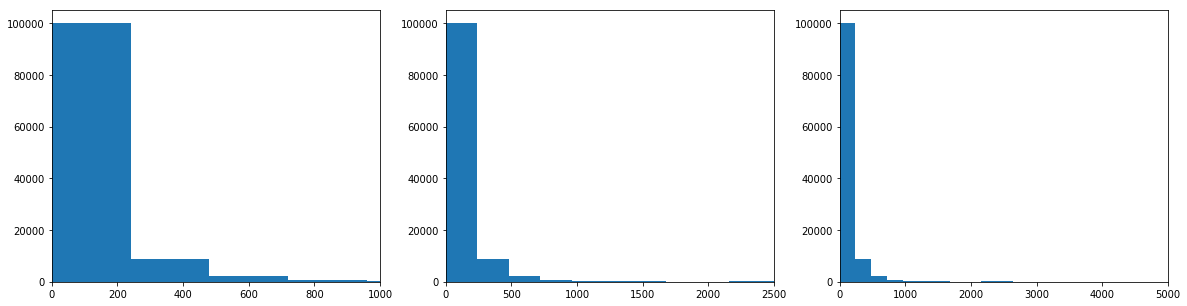

In [37]:
train_doc_lens = [len(doc.split(' ')) for doc in train_text]
f, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].hist(train_doc_lens, bins=100)
ax[0].set_xlim([0, 1000])

ax[1].hist(train_doc_lens, bins=100)
ax[1].set_xlim([0, 2500])

ax[2].hist(train_doc_lens, bins=100)
ax[2].set_xlim([0, 5000])

In [38]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
       When running eval/predict on the TPU, we need to pad the number of examples
       to be a multiple of the batch size, because the TPU requires a fixed batch
       size. The alternative is to drop the last batch, which is bad because it means
       the entire output data won't be generated.
       We use this class instead of `None` because treating `None` as padding
       batches could cause silent errors.
  """
    
    
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [39]:
def create_tokenizer_from_hub_module(bert_path):
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  tf_hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

In [40]:
def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=text, text_b=None, label=label)
        )
    return InputExamples

In [41]:
def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

In [42]:
# Initialize session
sess = tf.Session()

# Params for bert model and tokenization
BERT_PATH = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
MAX_SEQ_LENGTH = 512

In [43]:
# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module(bert_path=BERT_PATH)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0702 04:41:11.638050 139846337992512 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [44]:
train_text_lengths = np.array([len(doc.split(' ')) for doc in train_text])
test_text_lengths = np.array([len(doc.split(' ')) for doc in test_text])

In [50]:
train_text_idx = np.argwhere(train_text_lengths >= 5).ravel()
test_text_idx = np.argwhere(test_text_lengths >= 5).ravel()

train_text = [train_text[i] for i in train_text_idx]
train_labels = [train_labels[i] for i in train_text_idx]
test_text = [test_text[i] for i in test_text_idx]
test_labels = [test_labels[i] for i in test_text_idx]

len(train_text), len(train_labels), len(test_text), len(test_labels)

(112291, 112291, 37408, 37408)

In [51]:
# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, train_labels)
test_examples = convert_text_to_examples(test_text, test_labels)

In [52]:
(train_input_ids, train_input_masks, 
 train_segment_ids, train_labels) =  convert_examples_to_features(tokenizer=tokenizer, 
                                                                  examples=train_examples, 
                                                                  max_seq_length=MAX_SEQ_LENGTH)

(test_input_ids, test_input_masks, 
 test_segment_ids, test_labels) =  convert_examples_to_features(tokenizer=tokenizer, 
                                                                examples=test_examples, 
                                                                max_seq_length=MAX_SEQ_LENGTH)

In [53]:
train_input_ids.shape, test_input_ids.shape

((112291, 512), (37408, 512))

In [54]:
bm = tf_hub.Module(BERT_PATH, trainable=True, name=f"bert_module")
bm

In [55]:
class BertLayer(tf.layers.Layer):
    
    def __init__(self, bert_path, n_fine_tune_encoders=10, **kwargs,):
        
        self.n_fine_tune_encoders = n_fine_tune_encoders
        self.trainable = True
        self.output_size = 768
        self.bert_path = bert_path
        super(BertLayer, self).__init__(**kwargs)

        
    def build(self, input_shape):
        self.bert = tf_hub.Module(self.bert_path,
                                  trainable=self.trainable, 
                                  name=f"{self.name}_module")

        # Remove unused layers
        trainable_vars = self.bert.variables
        trainable_vars = [var for var in trainable_vars 
                                  if not "/cls/" in var.name]
        trainable_layers = ["embeddings", "pooler/dense"]


        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_encoders+1):
            trainable_layers.append(f"encoder/layer_{str(10 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [var for var in trainable_vars
                                  if any([l in var.name 
                                              for l in trainable_layers])]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:# and 'encoder/layer' not in var.name:
                self._non_trainable_weights.append(var)
        print('Trainable layers:', len(self._trainable_weights))
        print('Non Trainable layers:', len(self._non_trainable_weights))

        super(BertLayer, self).build(input_shape)

        
    def call(self, inputs):
        
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(input_ids=input_ids, 
                           input_mask=input_mask, 
                           segment_ids=segment_ids)
        
        pooled = self.bert(inputs=bert_inputs, 
                           signature="tokens", 
                           as_dict=True)["pooled_output"]

        return pooled

    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size) 

In [56]:
# Build model
def build_model(bert_path, max_seq_length, n_fine_tune_encoders=10): 
    
    inp_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    inp_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    inp_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [inp_id, inp_mask, inp_segment]
    
    bert_output = BertLayer(bert_path=bert_path, 
                            n_fine_tune_encoders=n_fine_tune_encoders)(bert_inputs)
    
    dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(lr=2e-5), 
                  metrics=['accuracy'])    
    return model

In [57]:
def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [58]:
model = build_model(bert_path=BERT_PATH, max_seq_length=MAX_SEQ_LENGTH, n_fine_tune_encoders=10)

# Instantiate variables
initialize_vars(sess)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0702 05:46:25.326409 139846337992512 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Trainable layers: 199
Non Trainable layers: 5
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0702 05:46:27.496462 139846337992512 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [59]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 512)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
bert_layer_1 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]                
          

In [60]:
model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_split=0.1,
    epochs=3,
    batch_size=15,
    verbose=1
)

/home/redanalyze/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 101061 samples, validate on 11230 samples
Epoch 1/3
101061/101061 [==============================] - 14260s 141ms/step - loss: 0.1429 - acc: 0.9509 - val_loss: 0.0990 - val_acc: 0.9660
Epoch 2/3
101061/101061 [==============================] - 14258s 141ms/step - loss: 0.0882 - acc: 0.9692 - val_loss: 0.0857 - val_acc: 0.9705
Epoch 3/3
  5880/101061 [>.............................] - ETA: 3:34:54 - loss: 0.0649 - acc: 0.9716

KeyboardInterrupt: 

In [61]:
test_predictions = model.predict(x=[test_input_ids, 
                                    test_input_masks, 
                                    test_segment_ids],
                                 batch_size=200,
                                 verbose=1)

37408/37408 [==============================] - 1986s 53ms/step


In [62]:
test_predictions = test_predictions.ravel()

In [75]:
test_pred_labels = [1 if prob > 0.5 else 0 for prob in test_predictions]

In [76]:
from sklearn.metrics import confusion_matrix, classification_report

print('Classification Report:')
print(classification_report(y_true=test_labels, y_pred=test_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     31617
           1       0.89      0.89      0.89      5791

    accuracy                           0.97     37408
   macro avg       0.93      0.93      0.93     37408
weighted avg       0.97      0.97      0.97     37408



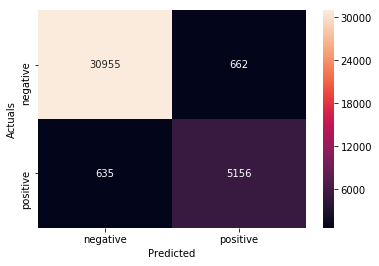

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

with tf.Session() as session:
    cm = tf.confusion_matrix(test_labels, test_pred_labels).eval()

LABELS = ['negative', 'positive']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

In [78]:
model.save_weights('bert_security_model_weights_seq512b15.h5')

In [79]:
model.save('bert_security_model_seq512b15.h5')

### This is not complete I still need to run some experiments but didn't get time considering it takes 4 hours per epoch :)